In [1]:
### Author: Leonie Küchenhoff
### Date: December 7 2022
### Purpose of script: 
### Import reads exported with reditools in all potential off-target sites (found by cas-offinder, <= 5 mismatches to gRNA) and plot to see a trend

In [1]:
# package import
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
from config import basedir, outdir, cas_offinder
import glob
import matplotlib.patches as mpatches

In [2]:
# general info
os.chdir(basedir)
outdir = str(outdir + '/offinder')
print('This base directory will be used:\n', basedir)
off_dir = cas_offinder
# sample names
names = ['028_pbs_R', '029_pbs_R', '032_pbs_R','033_nrch_R', '030_nrch_R', '036_nrch_R', 
            '011_pbs', '012_nrch', '013_nrch', '014_nrch', '279_spry', '321_pbs', '333_pbs', '450_spry', '283_spry']
# treatment in same order as sample names
base_editor = ['pbs', 'pbs', 'pbs', '8e-NRCH', '8e-NRCH', '8e-NRCH',
            'pbs', '8e-NRCH', '8e-NRCH','8e-NRCH', 'max-SpRY', 'pbs', 'pbs', 'max-SpRY', 'max-SpRY']

pairing = dict(zip(names, base_editor))
mutation = ['r636q' if i[-1] == 'R' else 'p635l' for i in names]

categories = 'pspry','pnrch','rnrch'

chromosomes = ['chr1','chr2','chr3','chr4','chr5','chr6', 'chr7', 'chr8', 'chr9','chr10',
'chr11','chr12','chr13','chr14','chr15','chr16', 'chr17', 'chr18', 'chr19']

This base directory will be used:
 /g/steinmetz/project/leonie_crispr/03_data/02_rnaseq/snakemake/


In [3]:
# general plot settings
plt.rcParams.update({'font.size':18, 'text.usetex': False,
"svg.fonttype": 'none'})

In [4]:
# get file path names for each category
pspry= glob.glob(f'{off_dir}/H*pspry.redi.txt')
pnrch= glob.glob(f'{off_dir}/H*pnrch.redi.txt')
rnrch= glob.glob(f'{off_dir}/H*rnrch.redi.txt')

In [5]:
relative_positions = list(range(0, 41))
position_df = {}
for name in ['off_target_nrch_p', 'off_target_nrch_r', 'off_target_spry']:
    '''
    for loop to read bed files and annotate each base with a position relative to gRNA
    retunrs dict with three entries - one entry for each gRNA + PAM with each position annotated with a realtive position
    '''
    path = f'offinder/{name}.bed'
    bed_df = pd.read_csv(path, sep = '\t', header = None, names = ['chr', 'start', 'stop'])
    sample_pos = {}
    for index, row in bed_df.iterrows():
        a = list(range(row['start'], row['start'] +41))
        positions = [row['chr'] + str(i) for i in a]
        sample_pos[index] = positions
    position_frame = pd.DataFrame.from_dict(sample_pos)
    position_frame['relative_position'] = relative_positions
    position_frame = position_frame.melt(id_vars = 'relative_position').drop(columns = 'variable')
    position_df[name] = position_frame

In [6]:
def read_files_rel_pos(path_list, mutation):
    '''
    function to read reditools output files from path list & annotate them with realtive positions from position_df dict
    returns
        - dictonary containing one entry per file
        - corresponding file names in list
    '''
    dict = {}
    kurz = []
    for j in path_list:
        name = os.path.basename(j).split('.')[0][1:]
        condition = pairing[name]
        file = pd.read_csv(j, sep = '\t')
        file = file[file['Region'].isin(chromosomes)]
        file = file[file['Coverage-q30']>=5]
        file = file[~(file['Position']>=53843223)& (file['Position']<=53843268) & (file['Region']>='chr19')]

        file['value'] = file['Region'] + [str(x) for x in file['Position']]
        condition = pairing[name]
        file_rel = file.merge(position_df[mutation], how = 'left', on = 'value')
        file_rel['condition'] = condition
        file_rel['sample'] = name
        dict[name] = file_rel
        kurz.append(name)
    return dict, kurz

In [7]:
all_pos = pd.DataFrame({'relative_position': list(range(0,41))})

In [9]:
# for each condition, read readi files & annotate with relative postion
test_rnrchr, kurz_rnrchr = read_files_rel_pos(rnrch, 'off_target_nrch_r')
# conctenate all sample files to one df
concatenated_nrchr = pd.concat([test_rnrchr[i] for i in kurz_rnrchr])
# Search for variants
plot_rnrch = concatenated_nrchr[concatenated_nrchr['Frequency']>0].groupby(['relative_position', 'condition']).count()['Frequency'].to_frame(name = 'count').reset_index()
# merge with empty df containing all realtive positions to make format consistent
plot_rnrch = all_pos.merge(plot_rnrch, how = 'left', on = 'relative_position')



# repeat procedure described above for other conditions

test, kurz = read_files_rel_pos(pnrch, 'off_target_nrch_p')
concatenated_nrchp = pd.concat([test[i] for i in kurz])
plot_pnrch = concatenated_nrchp[concatenated_nrchp['Frequency']>0].groupby(['relative_position', 'condition']).count()['Frequency'].to_frame(name = 'count').reset_index()
plot_pnrch = all_pos.merge(plot_pnrch, how = 'left', on = 'relative_position')

test, kurz = read_files_rel_pos(pspry, 'off_target_spry')
concatenated_spryp = pd.concat([test[i] for i in kurz])
plot_pspry = concatenated_spryp[concatenated_spryp['Frequency']>0].groupby(['relative_position', 'condition']).count()['Frequency'].to_frame(name = 'count').reset_index()
plot_pspry = all_pos.merge(plot_pspry, how = 'left', on = 'relative_position')



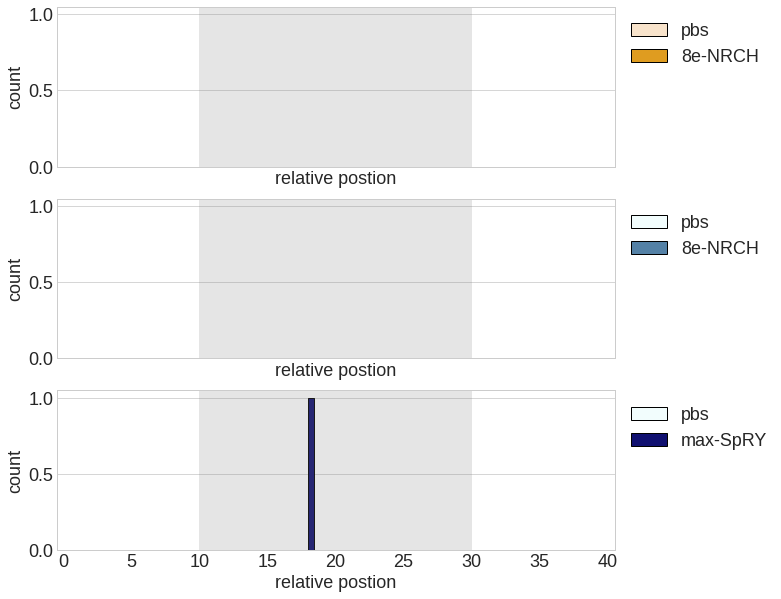

In [11]:

# plot results

fig, ax = plt.subplots(3,1, figsize = (10,10), sharex = True, sharey = True)
plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-whitegrid')
sns.barplot(x = 'relative_position', y = 'count', hue = 'condition', data = plot_rnrch, ax = ax[0], hue_order = ['pbs', '8e-NRCH'],edgecolor = 'black', linewidth = 1,palette = sns.color_palette(['bisque', 'orange']))
sns.barplot(x = 'relative_position', y = 'count', hue = 'condition', data = plot_pnrch, ax = ax[1], hue_order = ['pbs', '8e-NRCH'], edgecolor = 'black', linewidth = 1, palette = sns.color_palette(['azure', 'steelblue']))
sns.barplot(x = 'relative_position', y = 'count', hue = 'condition', data = plot_pspry, ax = ax[2], hue_order = ['pbs', 'max-SpRY'], edgecolor = 'black', linewidth = 1, palette = sns.color_palette(['azure', 'navy']))

ax[0].legend(bbox_to_anchor = (1, 1), loc = 'upper left')
ax[1].legend(bbox_to_anchor = (1, 1), loc = 'upper left')
ax[2].legend(bbox_to_anchor = (1, 1), loc = 'upper left')
ax[0].set_xlabel('relative postion')
ax[1].set_xlabel('relative postion')
ax[2].set_xlabel('relative postion')


left, bottom, width, height = (10, 0, 20, 3)
rect=mpatches.Rectangle((left,bottom),width,height, 
                        alpha=0.2,
                        facecolor="grey")

ax[0].add_patch(mpatches.Rectangle((left,bottom),width,height, 
                        alpha=0.2,
                        facecolor="grey"))
ax[1].add_patch(mpatches.Rectangle((left,bottom),width,height, 
                        alpha=0.2,
                        facecolor="grey"))
ax[2].add_patch(mpatches.Rectangle((left,bottom),width,height, 
                        alpha=0.2,
                        facecolor="grey"))

n = 5  
[l.set_visible(False) for (i,l) in enumerate(ax[2].xaxis.get_ticklabels()) if i % n != 0]
plt.show()

#fig.savefig(f'{outdir}/mut_pos.pdf', bbox_inches = 'tight')
#fig.savefig(f'{outdir}/mut_pos.svg', bbox_inches = 'tight')